Import packages

In [1]:
import env_methods as em
import vis_methods as vis
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import datetime as dt
import copy

Basic Parameters

In [2]:
#Define bounding box in North America
lat_start = 0
lat_end = 90
lon_start = -179
lon_end =  -30

#Data paths
main_path = r'C:\Users\bpara\Geo data'

temps_path = r'\temp'
geomean_path = r'\geopotential mean'
rain_path = r'\surface precip'

#Time stuff
month_to_show = 5 #What number of month to show, 0 = Dec 1843, 1 = Jan 1844, 2 = Feb 1844...

Import data

In [3]:
temp_data = em.get_data(main_path+temps_path, True)
temp_data["air"]=temp_data["nc_vars"].pop("air") #remove stacked structure
temp_data.pop("nc_vars")

geomean_data = em.get_data(main_path+geomean_path, True)
geomean_data["hgt"]=geomean_data["nc_vars"].pop("hgt")
geomean_data.pop("nc_vars")

rain_data = em.get_data(main_path+rain_path, True)
rain_data["apcp"] = rain_data["nc_vars"].pop("apcp")
rain_data.pop("nc_vars")

acquring data from air.2m.mon.mean.nc
acquring data from hgt.mon.mean.nc
acquring data from apcp.mon.mean.nc


{}

Define a function to produce mean values for a given month over a given timespan. Start year is inclusive, end year is exclusive

In [4]:
def generate_means(data, datakey, month, start_year, end_year, has_levels, level=0):
    start_time = dt.datetime(start_year, month, 1)
    end_time = dt.datetime(end_year, month, 1)
    start_index = em.find_closest_val(start_time, data["time"])
    end_index = em.find_closest_val(end_time, data["time"])
    dataset = data[datakey][start_index:end_index][::12]

    means = dict()
    means["lon"] = data["lon"][:]
    means["lat"] = data["lat"][:]
    
    if has_levels:
        temp = np.copy(dataset)[0][level]
    else:
        temp = np.copy(dataset)[0]
    
    for year in dataset[1:]:
        if has_levels:
            temp+=year[:,:][level]
        else:
            temp+=year[:,:]
    temp = temp / (end_year - start_year)
    means["mean"] = np.copy(temp)
    return means

Define a function to produce (sample) standard deviation values for a given month over a given timespan. Start year is inclusive, end year is exclusive

In [5]:
def generate_stddev(data, datakey, month, start_year, end_year, has_levels, level=0):
    start_time = dt.datetime(start_year, month, 1)
    end_time = dt.datetime(end_year, month, 1)
    start_index = em.find_closest_val(start_time, data["time"])
    end_index = em.find_closest_val(end_time, data["time"])
    
    dataset = np.copy(data[datakey][start_index:end_index][::12])
    means = np.copy(generate_means(data, datakey, month, start_year, end_year, has_levels, level)["mean"])
    stddev = dict()
    stddev["lat"] = data["lat"][:]
    stddev["lon"] = data["lon"][:]
    
    if has_levels:
        temp = np.square(dataset[0][level]-means)
    else:
        temp = np.square(dataset[0]-means)
        
    for year in range(1, len(dataset)):
        if has_levels:
            temp+=np.square(dataset[year][level]- means)
        else:
            temp+=np.square(dataset[year]-means)
    temp = temp / (end_year - start_year - 1)
    temp = np.sqrt(temp)
    
    stddev["stddev"] = np.copy(temp)
    
    return stddev

Define a function to produce a z-score for each data point to tell how many standard deviations from the mean it is for a given month when compared to a given date range

In [6]:
def generate_z_score(data, datakey, month, start_year, end_year, focus_year, has_levels, level=0):
    focus_time = dt.datetime(focus_year, month, 1)
    focus_index = em.find_closest_val(focus_time, data["time"])
    
    means = np.copy(generate_means(data, datakey, month, start_year, end_year, has_levels, level)["mean"])
    stddevs = np.copy(generate_stddev(data, datakey, month, start_year, end_year, has_levels, level)["stddev"])
    
    z_score = dict()
    z_score["lon"] = data["lon"][:]
    z_score["lat"] = data["lat"][:]
    
    if has_levels:
        temp = np.copy(data[datakey][focus_index][level])
    else:
        temp = np.copy(data[datakey][focus_index])
    temp = temp - means
    temp = temp / stddevs
    
    z_score["score"] = np.copy(temp)
    
    return z_score

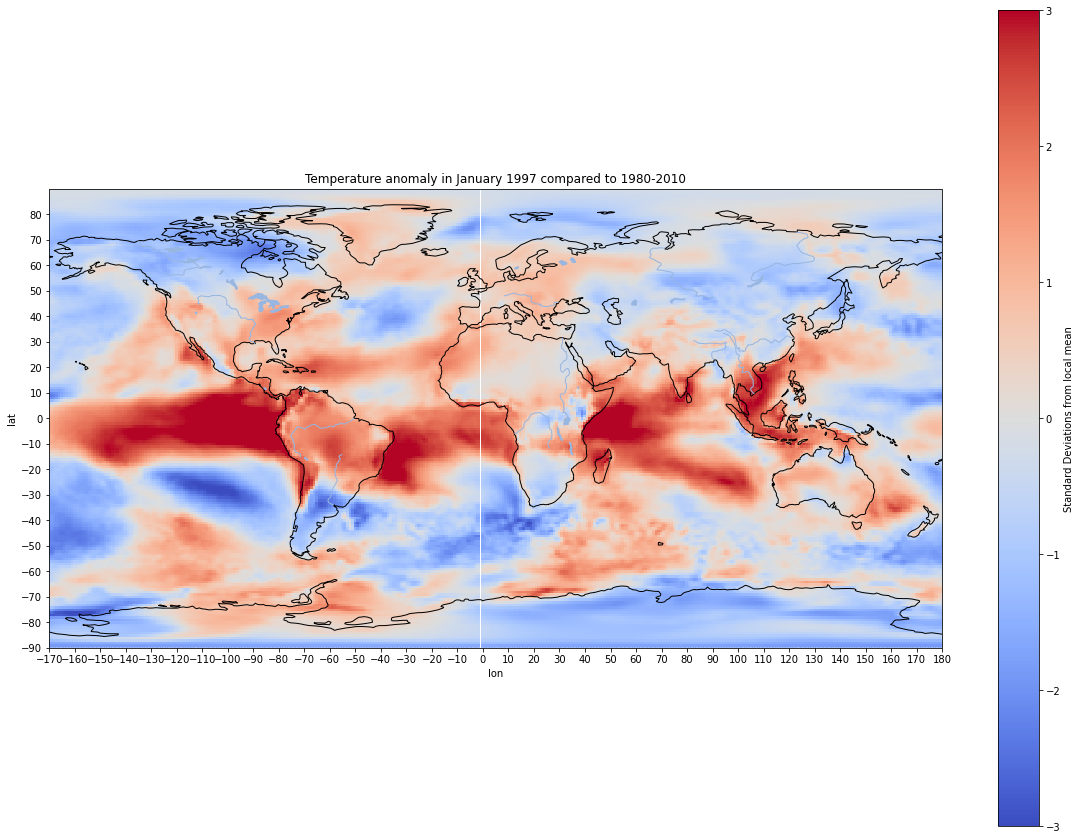

In [25]:
temp_z_score = generate_z_score(temp_data, "air", 1, 1980, 2010, 1998, False)

vis.plot_data(temp_z_score["lon"], temp_z_score["lat"], temp_z_score["score"], 
              "Standard Deviations from local mean", "Temperature anomaly in January 1997 compared to 1980-2010",
              has_scale_bounds = True, scale_min = -3, scale_max = 3)

<ipython-input-6-9f032a399aa6>:17: RuntimeWarning: invalid value encountered in true_divide
  temp = temp / stddevs


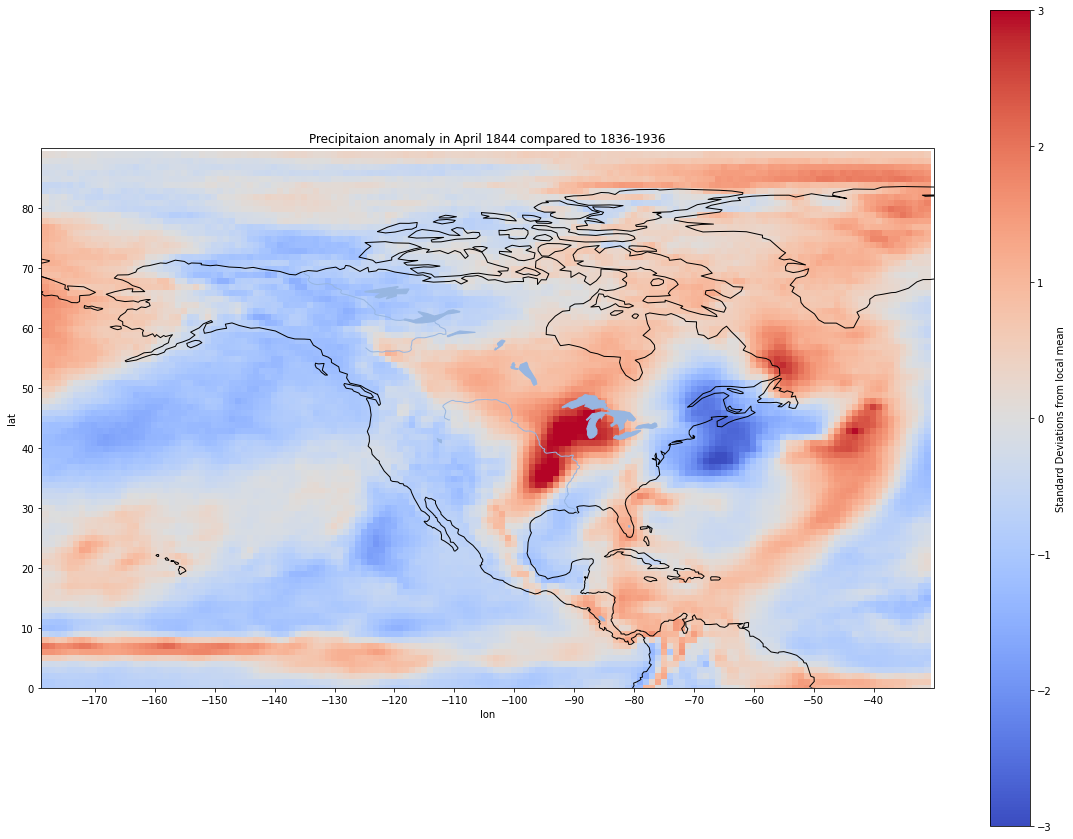

In [16]:
rain_z_score = generate_z_score(rain_data, "apcp", 4, 1836, 1936, 1844, False)

vis.plot_data(rain_z_score["lon"], rain_z_score["lat"], rain_z_score["score"], 
              "Standard Deviations from local mean", "Precipitaion anomaly in April 1844 compared to 1836-1936", 
              has_scale_bounds = True, scale_min = -3, scale_max = 3, 
              lon_min = lon_start, lon_max = lon_end, lat_min = lat_start, lat_max = lat_end)